# Cusom datasets

This part will focus on creating a dataset and then predicting on it
The dataset chosen is a subset of the Food101 dataset and contains 3 different classes: 
* Pizza
* Steak
* Sushi

## Basics

### Imports 

In [1]:
# Imports
import torch as pt
from torch import nn

print(f"Torch version: {pt.__version__}")


Torch version: 2.0.1


In [2]:
# Setup device agnostic code
device = 'cuda' if pt.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cpu


### Downloading a custom dataset

In [3]:
from pathlib import Path
import importLib
from sys import path
import zipfile


# Create directory
data_path = Path(f"{path[0]}/data")
image_path = data_path / 'pizza_steak_sushi'
if image_path.exists():
    print('Already exists')
else:
    image_path.mkdir(parents=True)


# Download pizza, steak and sushi data
# open skapar en zip fil som sedan fylls genom request
importLib.import_from_github('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',directory=data_path)
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data')
    zip_ref.extractall(image_path)
Path.unlink(data_path/'pizza_steak_sushi.zip')


Already exists
/Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi.zip doesn't exist, download
Unzipping pizza, steak and sushi data


### Become one with the data

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path and returns its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
walk_through_dir(image_path)

There are 2 directories and 0 images in /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi
There are 3 directories and 0 images in /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test
There are 0 directories and 19 images in /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/train
There are 0 directories and 75 images in /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in /Users/gustavgams

In [5]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/train'),
 PosixPath('/Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test'))

### Visualize an image

Let's write some code to:
1. Get all the image paths (pathlib)
2. Pick a random path
3. Get the image class name, by looking at the pathlib.Path.parent.stem
4. Since we are working with images, we will open it with PIL
5. Show image and print metadata


This globs together all the 300 images inside pizza_steak_sushi
Chosen random image: 648055.jpg
Class is a: pizza
Height: 512
Width: 512


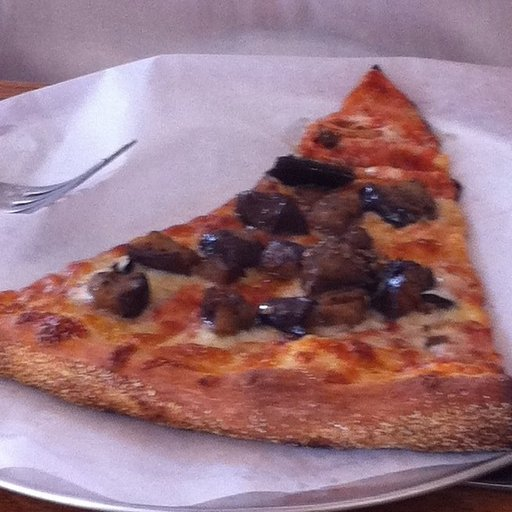

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from torchvision import transforms
from PIL import Image
# Set seed
seed = None
random.seed(None)

# 1. Get all image paths
image_path_list = (list(image_path.glob('*/*/*.jpg'))) # glob together every image with a certain pattern
print(f'This globs together all the {len(image_path_list)} images inside pizza_steak_sushi')
random_image_path = random.choice(image_path_list)
print("Chosen random image: "+random_image_path.name)
print('Class is a: '+random_image_path.parent.stem)
img = Image.open(random_image_path)
print(f"Height: {img.height}")
print(f"Width: {img.width}")
img

torch.Size([3, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

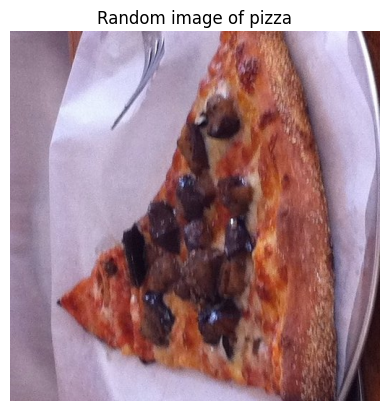

In [7]:
tensor = transforms.Compose([transforms.PILToTensor()])(img)
print(tensor.shape)
tensor = tensor.permute(2, 1,0)
# plot image
plt.title(f'Random image of {random_image_path.parent.stem}')
plt.imshow(tensor)
plt.axis(False)

### Transforming data

Before we can use our data:
1. Turn target data to tensors, in this case: Pictures -> tensors
2. Turn it to a `torch.utils.data.Dataset` and subsequently (afterwards) into a `torch.utils.data.Dataloader`, (Batched dataset)

Information and help regarding transforms: https://pytorch.org/vision/stable/transforms.html

In [8]:
import torch as pt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
# Write a transform for image
# transforms.Compose is similar to nn.Sequential where it can hold many different transforms
data_transform = transforms.Compose([
    # Resize our images to a set size to ensure compability with our modules shape handeling
    transforms.Resize(size=(64, 64)),
    # Flip the image half of the time it goes through this pipeline
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

(-0.5, 63.5, 63.5, -0.5)

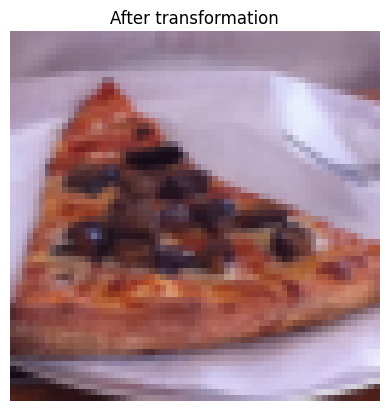

In [10]:
plt.title('After transformation')
plt.imshow(data_transform(img).permute(1,2,0))
plt.axis(False)

In [11]:
def plot_transformed_images(image_paths:str, transform:transforms, n:int=3, generator_seed:int=None, transform_seed:int=None):
    """Plot difference between transformed images and normal
    
    args:
        image_paths (Sequence[Path()]): List of image file paths.
        transform (torchvision.transforms): Image transformation object.
        num_images (int, optional): Number of images to display. Default is 3.
        generator_seed (int, optional): Random seed for image selection. Default is None.
        generator_seed (int, optional): Random seed for transform selection. Default is None."""
    from random import sample, seed as random_seed
    random_seed(generator_seed)
    pt.manual_seed(transform_seed)
    image_paths = sample(image_paths,k=n)
    fig, ax = plt.subplots(nrows=len(image_paths),ncols=2)
    for i,img_path in enumerate(image_paths):
        with Image.open(img_path) as f:
            ax[i,0].imshow(f)
            ax[i,1].imshow(transform(f).permute(1,2,0))
            ax[i,0].axis(False)
            ax[i,0].set_title(f"Size: {f.size}")
            ax[i,1].axis(False)
            ax[i,1].set_title(f'Size: ({str(transform(f).permute(1,2,0).size())[12:-2]})')

    plt.tight_layout(w_pad=-10)

    plt.subplots_adjust(top=0.8)
    plt.suptitle('Images\nOriginal    Transformed', fontsize=20)
    plt.show()

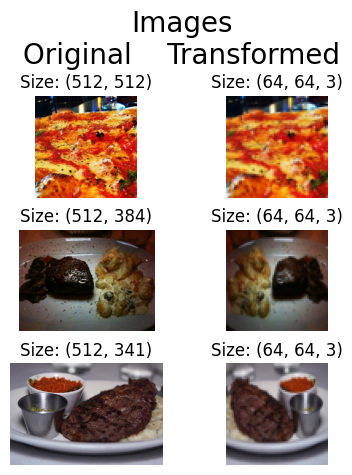

In [13]:
plot_transformed_images(image_path_list, data_transform,3,generator_seed=42, transform_seed=42)

## Loading all of our images


Option 1: Loading image data usin `ImageFolder`: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

Option 2: Do it by yourself


### ImageFolder

In [14]:
from torchvision import datasets
# the ImageFolder class makes a division automaticly without having to hardcode it, because we have our data already structured in the pytorch style with first the dataset then train and test dir with pictures in them 
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, # a transform for the data
                                  target_transform=None, # a transform for the targets/labels
                                  )
test_data = datasets.ImageFolder(root=test_dir, 
                                  transform=data_transform, # a transform for the data
                                  target_transform=None, # a transform for the targets/labels
                                  )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

(-0.5, 63.5, 63.5, -0.5)

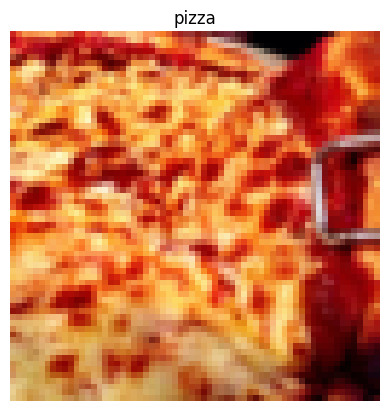

In [15]:
random.seed(42)
img = random.choice(test_data)
plt.imshow(img[0].permute(1,2,0))
plt.title(test_data.classes[img[1]])
plt.axis(False)

#### Dataloaders

In [16]:
BATCH_SIZE = 32
NUM_WORKERS = 4
print(f"Cpu cores available: {os.cpu_count()}")



# Ett alternativ för drop last: 

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS) # Basically how many cpu cores are used to load the data, sätts ofta till os.cpu_count() alltså alla som ges

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)
 # Basically how many cpu cores are used to load the data, sätts ofta till os.cpu_count() alltså alla som ges


Cpu cores available: 4


In [17]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [18]:
img, label = next(iter(train_dataloader))
print(img.shape, label)

torch.Size([32, 3, 64, 64]) tensor([0, 2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 2, 2, 1, 1, 0, 2,
        2, 2, 2, 1, 2, 2, 2, 2])


### By our own

#### Preparation

1. We want to be able to load images from file
2. We want to be able to get classes from Dataset
3. We want to get classes as dict as well

All custom datasets in python often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [19]:
from torch.utils.data import Dataset
import os
import pathlib
import torch as pt
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

##### Creating a helper function to get class names and one for class names as dict

We want our function to
1. Get the class names using `os.scandir()` to traverse a target directory
2. Raise an error if the class names are not found
3. Turn the class names into a dict and a list and return them


In [20]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
dict([(class_name, i) for i, class_name in enumerate(class_names_found)])

Target dir: /Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/train


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
def get_classes(directory:str) -> List[str]:
    classes = sorted([entry.name for entry in list(os.scandir(directory))])
    classes_to_idx =  {class_name:i for i, class_name in enumerate(class_names_found)}
    return classes, classes_to_idx
    


#### Create a custom `dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Initialize our subclass with target dir as well as transform with transforms
3. Create several attributes:
    * paths - the paths of our images
    * transform - the transform we would like to use
    * classes - a list of the target classes
    * classes_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images() to open an image
5. Overwrite the __len__() method to return the length of the dataset
6. Overwrite the __getitem__() method to return a given sample when passed an index


Pros:
* Customizability

Con:
* Prone to errors


In [22]:
# Write a cutom dataset class
from torch.utils.data import Dataset
from PIL import Image

class ImageFolderCustom(Dataset):
    def __get_classes(self):
        classes = sorted([entry.name for entry in list(os.scandir(self.targ_dir))])
        classes_to_idx = {class_name:i for i, class_name in enumerate(classes)}
        return classes, classes_to_idx

    def __get_class(self, directory:str) -> str:
        return self.classes_to_idx[Path(directory).parent.name]


    def __init__(self, targ_dir:str, transform=None):
        super().__init__()
        self.targ_dir = targ_dir

        # Create class attributes

        # Get all of the image paths
        # alltså tar denna in exempelvis test foldern som targ_dir och tar alla värden från foldrarna i den som slutar på jpg
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) 
        
        # Setup transforms
        self.transform = transform
        
        # Create classes and class_to_idx attributes
        self.classes, self.classes_to_idx = self.__get_classes()

        # Create targets
        self.targets = [self.__get_class(el) for el in self.paths]
    def load_image(self, index:int) -> Image.Image: 
        """Opens an image via path using index and returns it"""
        return Image.open(self.paths[index])

    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)

    def __getitem__(self, index) -> Tuple[pt.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # gets the folder and then takes the parents name, i.e pizza/steak/sushi
        class_idx = self.classes_to_idx[class_name] # Uses the dictionary classes_to_idx to get the index of the class

        if self.transform: # Om man har specifierat self.transform så den inte är None
            return self.transform(img), class_idx
        return img, class_idx


train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform= None
)

#### Test  the dataset with Dataloaders

In [23]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(0.5), # "artificially changing our data to broaden the dataset"
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)), # Här skippar vi data augmentation, alltså förändring av data för att bredda utbudet av data för bättre träning, då detta ändå bara är till testande
    transforms.ToTensor() 
])

In [24]:
train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform= train_transform
)
test_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform= test_transform
)

In [25]:
print(test_data_custom, test_data_custom)

print("\n", len(train_data), len(train_data_custom))

print(train_data.classes, train_data_custom.classes)

<__main__.ImageFolderCustom object at 0x11e0fb190> <__main__.ImageFolderCustom object at 0x11e0fb190>

 225 225
['pizza', 'steak', 'sushi'] ['pizza', 'steak', 'sushi']


#### Test by visualization

1. Take in a `dataset` + other parameters for visualization
2. Cap number of images to see at ten

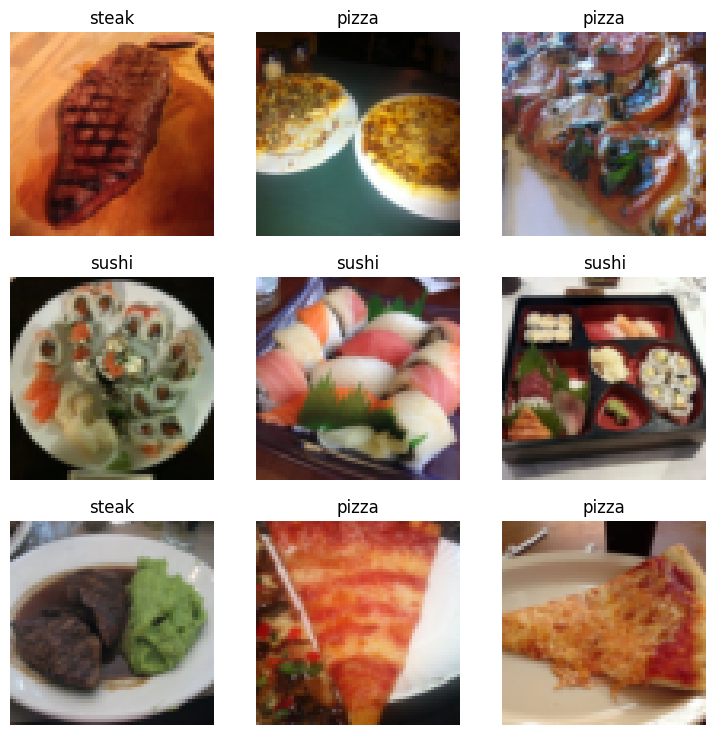

In [26]:
from ml_funcs import view
view.rand_images(test_data_custom,seed=42)

#### Turn custom loaded images into DataLoader's 

In [27]:
from torch.utils.data import DataLoader
from numpy import round
BATCH_SIZE = 32

#NUM_WORKERS = 2 # How many cpu cores we will use
print(f"Cpu cores available: {os.cpu_count()}") # optionally we can make num_workers to this, or a part of this, by code examplewise
NUM_WORKERS = int(round(os.cpu_count()*(3/4))) # Här kan man välja hur många cores som används


print(NUM_WORKERS)
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)

train_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)


Cpu cores available: 4
3


## Data augmentation (just a snippet, but a general one)

`A technic used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing model`

Examples of ways to do so:
* Rotate
* Shift, move the picture a bit right, left, up, down
* Zoom
* There are many more...

___

`A technic to train PyTorch vision models used in to state of the art models: (SOTA)`

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

One example of a way to further advance our model is by using trivialaugmentation (which automatically does some of these data augmentations)

In [28]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
    # num_magnitude_bins is basically in which intensity you want your pictures to change
])

test_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.ToTensor()
])



In [29]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:3]

[PosixPath('/Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('/Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('/Users/gustavgamstedt/Desktop/github to hemma/PyTorch/04/video/data/pizza_steak_sushi/test/steak/894825.jpg')]

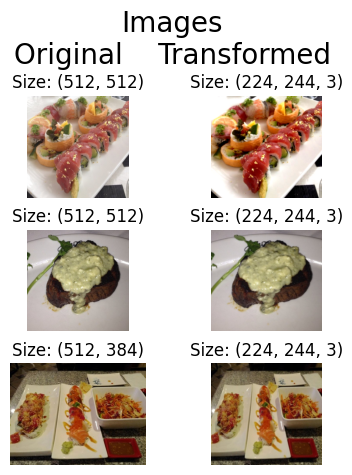

In [30]:
plot_transformed_images(image_path_list, train_transform,n=3, generator_seed=None, transform_seed=42)


Let's repliate the TinyVGG architecture from CNN Explainer website